In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]
QDRANT_COLLECTION_NAME = "crawlai"
QDRANT_ENDPOINT = "https://78440471-16dc-4da1-8f1d-3ec406c0417c.us-east4-0.gcp.cloud.qdrant.io:6333"
GRADIO_PORT = 8080

In [75]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import OpenAI
from langchain_core.output_parsers.string import StrOutputParser
from googlesearch import search
import re
import lxml
from bs4 import BeautifulSoup
from langchain_community.document_loaders import RecursiveUrlLoader
from typing import Union
import requests
import aiohttp
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain_openai import OpenAI
from langchain_qdrant import QdrantVectorStore
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import gradio as gr
from gradio import ChatMessage

In [76]:
gen_searches_sys_prompt = (
    """
    You are a specialized AI Assistant helping a user create an LLM agent for them to use.
    The user is presumably non technical. Given the user request, consider which web searches would yield
    the most relevant information to add to the vector store of the user's new agent. Do NOT answer the
    user's request, just create three web search queries based on it to help populate the vector store with data.
    Make the three requests relatively varied, each of the requests will have the top website result fully scraped so
    you should make them varied to grab a wide range of information. Output three strings of the search requests separated
    by new lines.

    Here is an example (Do NOT use this directly):
    Question:
    Human: help me make assistant to apply to santa clara university
    
    Three Web Searches (separated by new lines):
    santa clara university main website
    \n
    applying to santa clara university
    \n
    santa clara university application requirements

    \n\n
    Question:
    """
)

gen_searches_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", gen_searches_sys_prompt),
        ("human", "{input}"),
        ("system", "\nThree Web Searches (separated by new lines):")
    ]
)

gen_searches_llm = OpenAI(temperature=0)
gen_searches_chain = gen_searches_prompt | gen_searches_llm | StrOutputParser()

print("created search gen llm")

def get_top_google_results(query, num_results=1):
    # Perform the search and return the top links
    return [link for link in search(query, num_results=num_results)]

def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()

def simple_metadata_extractor(raw_html: str, url: str, response: Union[requests.Response, aiohttp.ClientResponse]) -> dict:
    # Extract metadata from the response
    content_type = getattr(response, "headers").get("Content-Type", "")
    print(f"Loading: {url}  Content-Type: {content_type}")
    return {"source": url, "content_type": content_type}

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

rephraser_llm = OpenAI(temperature=0)

main_llm = OpenAI()

print("created chains")

created search gen llm
created chains


In [131]:
class GraphState(TypedDict):
    contextualized_question: str
    documents: list[str]
    messages: Annotated[list[AnyMessage], add_messages]

In [132]:

searches = gen_searches_chain.invoke("teach me how to bike like a pro")

lines = [line for line in searches.split('\n') if line.strip()]

print("found links")

links = []
for line in lines:
    links.extend(get_top_google_results(line))

docs = []
for link in links:
    if link.startswith("https://github.com/") or link.startswith("http://github.com/"):
        continue
    loader = RecursiveUrlLoader(link, extractor=bs4_extractor, metadata_extractor=simple_metadata_extractor, max_depth=3)
    docs.extend(loader.load())

splits = text_splitter.split_documents(docs)
splits = filter_complex_metadata(splits)

print("loading vectorstore")
#vector_store = Chroma.from_documents(splits, embeddings_model)

vector_store = QdrantVectorStore.from_documents(
    documents=splits,
    embedding=embeddings_model,
    url=QDRANT_ENDPOINT,
    collection_name=QDRANT_COLLECTION_NAME,
    api_key=QDRANT_API_KEY
)

print("loaded vectorstore")

found links
Loading: https://www.quora.com/How-do-I-ride-bike-like-a-professional-racer  Content-Type: text/html; charset=utf-8


Unable to load from https://www.pedalsure.com/blog/7-advanced-skills-for-cyclists-to-master. Received error HTTPSConnectionPool(host='www.pedalsure.com', port=443): Max retries exceeded with url: /blog/7-advanced-skills-for-cyclists-to-master (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020)'))) of type SSLError


Loading: https://www.wikihow.com/Become-a-Professional-Cyclist  Content-Type: text/html; charset=UTF-8
loading vectorstore
loaded vectorstore


In [133]:
# CONTEXTUALIZER

contextualize_q_sys_prompt = (
    """
    You are a specialized AI Assistant. Given a chat history and the latest user question which might reference context in the chat history, 
    formulate a standalone question which can be understood 
    without the chat history. Do NOT answer the question, just 
    reformulate it if needed and otherwise return it as is.
    Do NOT preceed your answer with any tags like System: or AI:.

    Here is an example:
    HISTORY:
    Human: what is an LLM?
    AI: an LLM is a large language model, a type of transformer machine learning algorithm used to interpret images and speech.
    \n
    QUESTION:
    Human: how do I make it?
    \n
    REPHRASED CONTEXTUALIZED QUESTION:
    How do I create an LLM transformer?
    \n\n
    HISTORY:
    \n
    """
)
contextualize_q_prompt = ChatPromptTemplate.from_messages([
        ("system", contextualize_q_sys_prompt),
        MessagesPlaceholder("chat_history"),
        ("system", "\nQUESTION:"),
        ("human", "{question}"),
        ("system", "\nREPHRASED CONTEXTUALIZED QUESTION:")
    ]
)

# Contextualizer Node: contextualize the user question using the message history
def contextualizer(state: GraphState):
    chat_history = state["messages"][:-1]
    input_question = state["messages"][-1]

    prompt = contextualize_q_prompt.invoke({"chat_history": chat_history, "question": input_question})

    result_question = rephraser_llm.invoke(prompt)
    return {"contextualized_question": result_question}

In [134]:
# RETRIEVER
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 30, "fetch_k": 10, "lambda_mult": 0.5})

# Document Retriever Node: updates the documents list with relevant docs for the contextualized question
def document_retriever(state: GraphState):
    contextualized_question = state["contextualized_question"]
    docs = retriever.invoke(contextualized_question)
    return {"documents": docs}

In [135]:
# GENERATOR
qa_sys_prompt = (
    """
    You are an assistant for question-answering tasks with retrieval augmented generation.
    Use the following pieces of retrieved context and the history of your interactions
    with the human to answer the question. If you don't know the answer, say that you
    don't know! Do not provide information if it is
    not in the context. Be descriptive. Do not complete or further generate the
    user's question. Do not refer to the context or history of interaction, do not use phrases like
    "according to the context" or "from the given documents". Do not refer to the context!
    \n\n
    CONTEXT:
    """
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_sys_prompt),
        ("human", "{context_documents}"),
        ("system", "\nCHAT HISTORY:"),
        MessagesPlaceholder("chat_history"),
        ("system", "\nQUESTION:"),
        ("human", "{question}"),
        ("system", "\nANSWER:")
    ]
)

# Generator Node: use documents and message history to answer the question
def answer_generator(state: GraphState):
    docs = state["documents"]
    partial_history = state["messages"][:-1]
    question = state["messages"][-1]

    prompt = qa_prompt.invoke({"context_documents": docs, "chat_history": partial_history, "question": question})

    answer = main_llm.invoke(prompt)

    updated_history = state["messages"]
    updated_history.append(AIMessage(content=answer))

    return {"messages": updated_history}

In [136]:
test_state = GraphState()

msgs = []
msgs.append(HumanMessage(content="hello, who is the chair of the computer science department?"))
msgs.append(AIMessage(content="The chair of the department is Silvia Figueira."))
msgs.append(HumanMessage(content="does Silvia Figueira, the chair of the department, have any research?"))
test_state["messages"] = msgs

docs = []
docs.append("Silvia Figueira is known for researching renewable energy sources.")
docs.append("Another promising project pursued by Santa Clara University is neural network heartrate monitor optimizations. Some of the contributors to this project are John Lee, Mark Fran and Silvia Figueira.")
docs.append("Santa clara university: nominated for Green Lives award in 2023 for renewable energy research by their professors.")
test_state["documents"] = docs

In [59]:
test_state

{'messages': [HumanMessage(content='hello, who is the chair of the computer science department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The chair of the department is Silvia Figueira.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='does Silvia Figueira, the chair of the department, have any research?', additional_kwargs={}, response_metadata={})],
 'documents': ['Silvia Figueira is known for researching renewable energy sources.',
  'Another promising project pursued by Santa Clara University is neural network heartrate monitor optimizations. Some of the contributors to this project are John Lee, Mark Fran and Silvia Figueira.',
  'Santa clara university: nominated for Green Lives award in 2023 for renewable energy research by their professors.']}

In [60]:
answer_generator(test_state)

<class 'str'>


{'messages': [HumanMessage(content='hello, who is the chair of the computer science department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The chair of the department is Silvia Figueira.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='does Silvia Figueira, the chair of the department, have any research?', additional_kwargs={}, response_metadata={}),
  AIMessage(content=' Yes, as mentioned earlier, Silvia Figueira is known for researching renewable energy sources and is a contributor to the neural network heartrate monitor optimizations project at Santa Clara University.', additional_kwargs={}, response_metadata={})]}

In [61]:
test_state

{'messages': [HumanMessage(content='hello, who is the chair of the computer science department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The chair of the department is Silvia Figueira.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='does Silvia Figueira, the chair of the department, have any research?', additional_kwargs={}, response_metadata={}),
  AIMessage(content=' Yes, as mentioned earlier, Silvia Figueira is known for researching renewable energy sources and is a contributor to the neural network heartrate monitor optimizations project at Santa Clara University.', additional_kwargs={}, response_metadata={})],
 'documents': ['Silvia Figueira is known for researching renewable energy sources.',
  'Another promising project pursued by Santa Clara University is neural network heartrate monitor optimizations. Some of the contributors to this project are John Lee, Mark Fran and Silvia Figueira.',
  'Santa clara university: nominated for

In [31]:
document_retriever(test_state)

{'documents': [Document(metadata={'source': 'https://www.wikihow.com/Swim-the-Butterfly-Stroke', 'content_type': 'text/html; charset=UTF-8', '_id': '35a0eca1-f459-4e2f-bc22-bf5827a5ddd8', '_collection_name': 'crawlai'}, page_content='The butterfly stroke is one of the most difficult swimming strokes. It is sometimes referred to as "Fly" for short. Although it is the second fastest stroke when done properly by a skilled athlete, it requires a very exact technique, strength and rhythm.  It does requires a lot of practice to perfect it, but when you have it right, it is one of the most rewarding, respected and aesthetically pleasing swimming styles currently used in competition. Being able to execute a good butterfly stroke is'),
  Document(metadata={'source': 'https://www.wikihow.com/Swim-Faster', 'content_type': 'text/html; charset=UTF-8', '_id': 'eb96715c-8d31-47af-ae29-cfeb90730eaf', '_collection_name': 'crawlai'}, page_content='This is a bit different when it comes to the breaststrok

In [137]:
def create_rag_graph():

    graph_builder = StateGraph(GraphState)
    graph_builder.add_node("contextualizer", contextualizer)
    graph_builder.add_node("document_retriever", document_retriever)
    graph_builder.add_node("answer_generator", answer_generator)

    graph_builder.add_edge(START, "contextualizer")
    graph_builder.add_edge("contextualizer", "document_retriever")
    graph_builder.add_edge("document_retriever", "answer_generator")
    graph_builder.add_edge("answer_generator", END)

    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

In [138]:
graph = create_rag_graph()

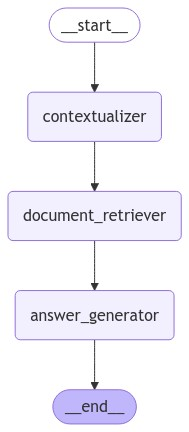

In [139]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [140]:
def ask_question(message, user_id):
    config = {"configurable": {"thread_id": user_id}}
    input = {"messages": [HumanMessage(content=message)]}
    final_state = graph.invoke(input, config=config)
    return final_state["messages"][-1]

In [142]:
ask_question("what are the steps to do that?", 1)

AIMessage(content="\nThe steps to mastering countersteering include learning to influence your bike's trajectory with deliberate pressure at the handlebars, focusing on the fundamentals, practicing and developing heightened awareness, and using smooth and controlled motions. Additionally, you can also try out advanced methods that work in tandem with countersteering to further refine your control and bolster your confidence.", additional_kwargs={}, response_metadata={}, id='16216bf0-62a5-40ce-a1f3-6ba8d63737dd')

In [122]:
config = {"configurable": {"thread_id": 1}}
print(graph.invoke({"messages": [HumanMessage(content="Hello, what is a hook in crochet?")]}, config=config)["messages"][-1])
print(graph.invoke({"messages": [HumanMessage(content="What is it made out of?")]}, config=config)["messages"][-1])
print(graph.invoke({"messages": [HumanMessage(content="Which one should I use?")]}, config=config)["messages"][-1])

content='\nIn crochet, a hook is a tool used to create crocheted items. It is usually made of metal, plastic, or wood and has a curved or pointed end to catch and pull yarn through loops. Hooks come in different sizes to accommodate different yarn thicknesses and can also have different handles to cater to different holding styles.' additional_kwargs={} response_metadata={} id='b51a5684-2a95-4688-9aca-61c391b007ee'
content='\nCrochet hooks can be made out of various materials such as metal, plastic, and wood.' additional_kwargs={} response_metadata={} id='af95ecf0-6573-4f65-a15d-5f16f1cf5e51'
content=' \n\nIt depends on your personal preference and the type of project you are working on. Some people prefer plastic or wood hooks for their lighter weight, while others prefer metal hooks for their durability and smoothness. It is recommended to try out different types of hooks and see which one feels most comfortable for you. ' additional_kwargs={} response_metadata={} id='a9e0c14d-5e84-4

In [107]:
msgs=[]
msgs.append(HumanMessage(content="Hello, what is a hook in crochet?"))
config = {"configurable": {"thread_id": 1}}
state = graph.invoke({"messages": msgs}, config=config)
print(state["messages"][-1])
state["messages"].append(HumanMessage("what is it usually made out of?"))
state = graph.invoke({"messages": state["messages"]}, config=config)
print(state["messages"][-1])
state["messages"].append(HumanMessage("which material should I choose?"))
state = graph.invoke({"messages": state["messages"]}, config=config)
print(state["messages"][-1])

messages=[SystemMessage(content='\n    You are a specialized AI Assistant. Given a chat history and the latest user question which might reference context in the chat history, \n    formulate a standalone question which can be understood \n    without the chat history. Do NOT answer the question, just \n    reformulate it if needed and otherwise return it as is.\n    Do NOT preceed your answer with any tags like System: or AI:.\n\n    Here is an example:\n    HISTORY:\n    Human: what is an LLM?\n    AI: an LLM is a large language model, a type of transformer machine learning algorithm used to interpret images and speech.\n    \n\n    QUESTION:\n    Human: how do I make it?\n    \n\n    REPHRASED CONTEXTUALIZED QUESTION:\n    How do I create an LLM transformer?\n    \n\n\n    HISTORY:\n    \n\n    ', additional_kwargs={}, response_metadata={}), SystemMessage(content='\nQUESTION:', additional_kwargs={}, response_metadata={}), HumanMessage(content="content='Hello, what is a hook in croch